In [27]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import glob
import cv2
from datetime import datetime

import tensorflow as tf

import segmentation_models as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
from keras.utils import to_categorical
from keras.utils import normalize
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU

from keras.models import load_model

from statistics import mode

print((tf.config.list_logical_devices("GPU")))
np.random.seed(42)

Segmentation Models: using `keras` framework.
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [2]:
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("../genratingimage/data/image/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
train_images = np.array(train_images)

train_masks = [] 
for directory_path in glob.glob("../genratingimage/data/ground/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [3]:
print(f"""
      image : {train_images.shape}
      grountruth : {train_masks.shape}""")


      image : (1000, 128, 128)
      grountruth : (1000, 128, 128)


In [4]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

c:\Users\tama\anaconda3\envs\tf11\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3], dtype=int64)

In [4]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

X1, X_val, y1, y_val = train_test_split(train_images, train_masks_input, test_size = 0.05, random_state = 0)

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print(f"Unique Values {np.unique(y_train)}" )

#train
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

#val
val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

#test
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print(f"jumlah train data : {len(y_train_cat)}")
print(f"jumlah val data : {len(y_val_cat)}")
print(f"jumlah test data : {len(y_test_cat)}")

Unique Values [0 1 2 3]
jumlah train data : 760
jumlah val data : 50
jumlah test data : 190


#### UNet 

In [5]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [6]:
n_classes=4
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [7]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optim, loss=total_loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_val, y_val_cat), 
                    #class_weight=class_weights,
                    shuffle=False, callbacks=[early_stopping])

Epoch 1/50
57/57 [==============================] - 19s 101ms/step - loss: 0.9681 - iou_score: 0.1481 - f1-score: 0.1764 - val_loss: 0.9280 - val_iou_score: 0.2088 - val_f1-score: 0.2276
Epoch 2/50
57/57 [==============================] - 4s 65ms/step - loss: 0.9105 - iou_score: 0.2374 - f1-score: 0.2435 - val_loss: 0.9265 - val_iou_score: 0.2068 - val_f1-score: 0.2264
Epoch 3/50
57/57 [==============================] - 4s 64ms/step - loss: 0.8992 - iou_score: 0.2453 - f1-score: 0.2511 - val_loss: 0.9175 - val_iou_score: 0.2176 - val_f1-score: 0.2327
Epoch 4/50
57/57 [==============================] - 4s 64ms/step - loss: 0.8868 - iou_score: 0.3350 - f1-score: 0.3992 - val_loss: 0.9225 - val_iou_score: 0.2983 - val_f1-score: 0.3675
Epoch 5/50
57/57 [==============================] - 4s 64ms/step - loss: 0.8656 - iou_score: 0.4642 - f1-score: 0.5828 - val_loss: 0.9409 - val_iou_score: 0.2814 - val_f1-score: 0.3409
Epoch 6/50
57/57 [==============================] - 4s 64ms/step - loss: 

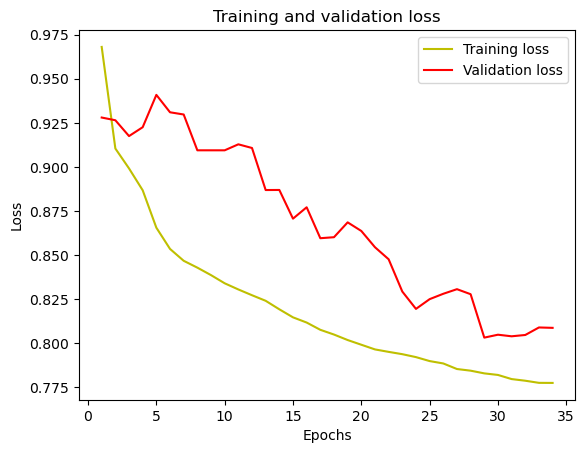

In [9]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


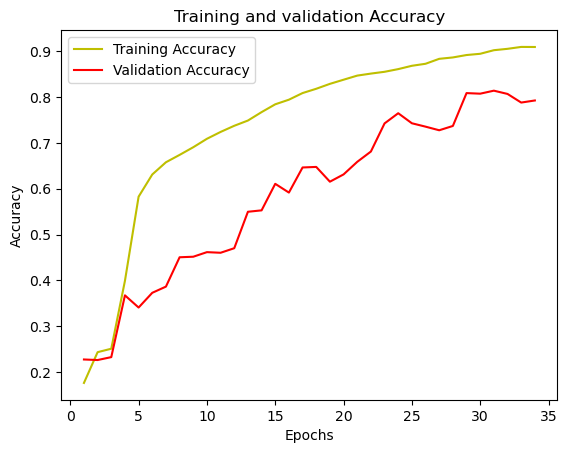

In [10]:
acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

2/2 [==============================] - 2s 12ms/step


In [12]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

Mean IoU = 0.6910404
[[6.85901e+05 2.07500e+03 4.84000e+03 2.60000e+01]
 [3.08000e+02 2.38100e+04 9.53800e+03 1.94300e+03]
 [1.13000e+02 1.40000e+02 3.66850e+04 8.48900e+03]
 [0.00000e+00 2.90000e+01 2.29000e+02 1.23060e+04]]
IoU for class1 is:  0.98938066
IoU for class2 is:  0.62917846
IoU for class3 is:  0.6110704
IoU for class4 is:  0.5345322


1/1 [==============================] - 1s 743ms/step


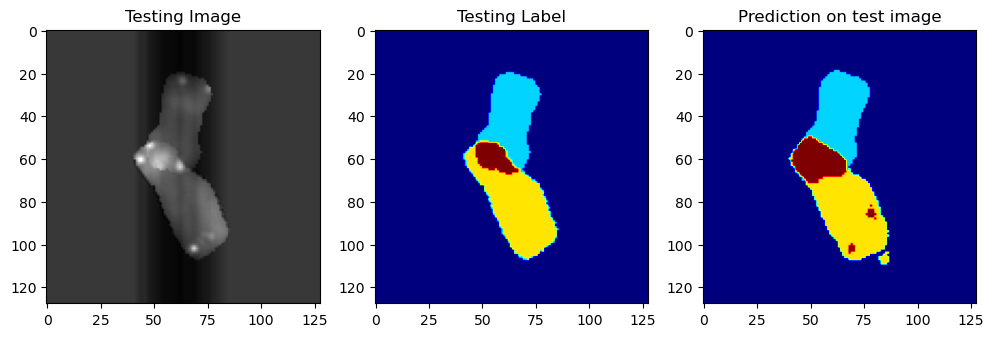

In [13]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()


### Training_ensemble

In [5]:
n_classes=4
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

#### model 1

In [6]:
N = X_train.shape[-1]
base_model = sm.Unet(backbone_name='resnet34', encoder_weights='imagenet', classes=4, activation=activation)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)
model1 = Model(inp, out, name=base_model.name)

model1.compile(optim, loss=total_loss, metrics=metrics)

In [7]:
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
history1=model1.fit(X_train, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_val, y_val_cat), shuffle=True)


Epoch 1/50
95/95 [==============================] - 23s 97ms/step - loss: 0.9595 - iou_score: 0.2961 - f1-score: 0.4006 - val_loss: 0.9768 - val_iou_score: 0.0046 - val_f1-score: 0.0090
Epoch 2/50
95/95 [==============================] - 8s 82ms/step - loss: 0.8830 - iou_score: 0.7343 - f1-score: 0.8371 - val_loss: 0.9592 - val_iou_score: 0.2187 - val_f1-score: 0.2333
Epoch 3/50
95/95 [==============================] - 8s 81ms/step - loss: 0.8350 - iou_score: 0.8258 - f1-score: 0.8999 - val_loss: 0.9630 - val_iou_score: 0.2209 - val_f1-score: 0.2346
Epoch 4/50
95/95 [==============================] - 8s 81ms/step - loss: 0.8025 - iou_score: 0.8661 - f1-score: 0.9254 - val_loss: 0.9700 - val_iou_score: 0.2209 - val_f1-score: 0.2346
Epoch 5/50
95/95 [==============================] - 8s 82ms/step - loss: 0.7854 - iou_score: 0.8876 - f1-score: 0.9385 - val_loss: 0.9797 - val_iou_score: 0.2209 - val_f1-score: 0.2346
Epoch 6/50
95/95 [==============================] - 8s 82ms/step - loss: 0

In [9]:
model1.save('./save_model_true_shuffle/res34.hdf5')

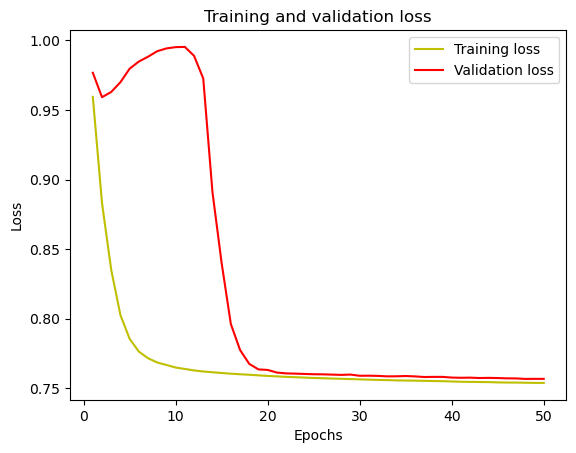

In [10]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

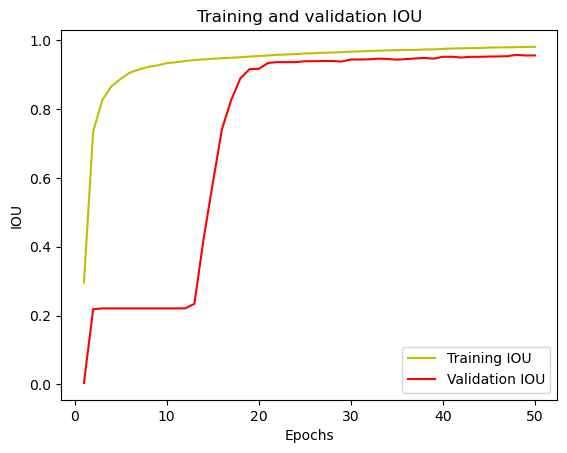

In [11]:
acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#### model2

In [7]:
tf.keras.backend.clear_session()
N = X_train.shape[-1]
base_model2 = sm.Unet(backbone_name='inceptionv3', encoder_weights='imagenet', classes=4, activation=activation)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model2(l1)
model2 = Model(inp, out, name=base_model2.name)

model2.compile(optim, total_loss, metrics=metrics)

In [8]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_94 (Conv2D)          (None, None, None, 3)     6         
                                                                 
 model (Functional)          (None, None, None, 4)     29933540  
                                                                 
Total params: 29,933,546
Trainable params: 29,897,130
Non-trainable params: 36,416
_________________________________________________________________


In [9]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
history2=model2.fit(X_train, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test_cat), shuffle=True,
          callbacks=[early_stopping])


Epoch 1/50
95/95 [==============================] - 36s 182ms/step - loss: 0.9627 - iou_score: 0.3043 - f1-score: 0.4295 - val_loss: 1.0066 - val_iou_score: 0.0019 - val_f1-score: 0.0039
Epoch 2/50
95/95 [==============================] - 14s 147ms/step - loss: 0.8955 - iou_score: 0.7343 - f1-score: 0.8411 - val_loss: 0.9550 - val_iou_score: 0.2267 - val_f1-score: 0.2501
Epoch 3/50
95/95 [==============================] - 14s 147ms/step - loss: 0.8559 - iou_score: 0.8378 - f1-score: 0.9081 - val_loss: 0.9263 - val_iou_score: 0.3183 - val_f1-score: 0.3748
Epoch 4/50
95/95 [==============================] - 14s 148ms/step - loss: 0.8265 - iou_score: 0.8735 - f1-score: 0.9300 - val_loss: 0.8849 - val_iou_score: 0.4796 - val_f1-score: 0.5761
Epoch 5/50
95/95 [==============================] - 14s 147ms/step - loss: 0.8016 - iou_score: 0.8955 - f1-score: 0.9433 - val_loss: 0.8239 - val_iou_score: 0.7648 - val_f1-score: 0.8588
Epoch 6/50
95/95 [==============================] - 14s 147ms/ste

In [10]:
model2.save('./save_model_true_shuffle/inceptionv3.hdf5')

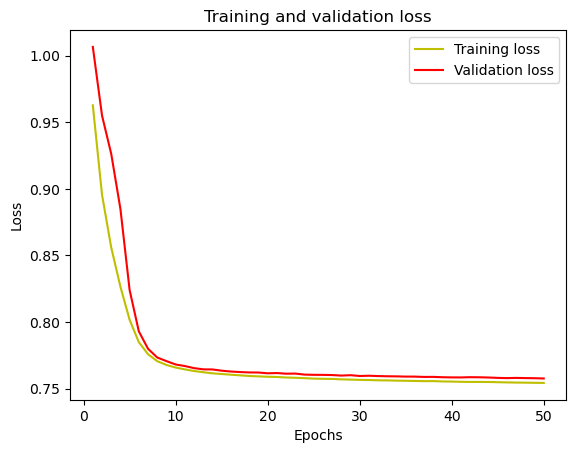

In [11]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

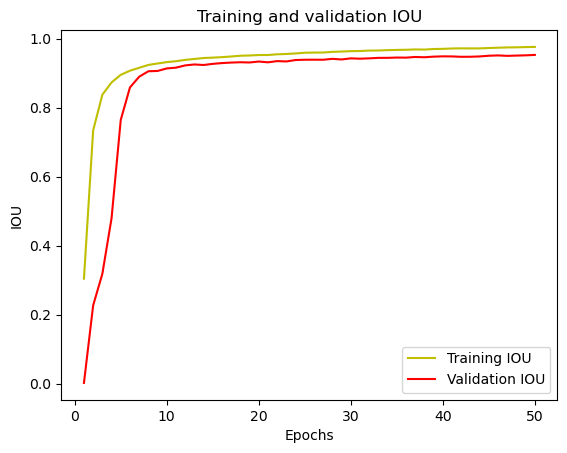

In [12]:
acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#### model 3

In [6]:
tf.keras.backend.clear_session()
N = X_train.shape[-1]
base_model3 = sm.Unet(backbone_name='vgg16', encoder_weights='imagenet', classes=4, activation=activation)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model3(l1)
model3 = Model(inp, out, name=base_model3.name)

model3.compile(optim, total_loss, metrics=metrics)

In [7]:
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 3)     6         
                                                                 
 model (Functional)          (None, None, None, 4)     23752708  
                                                                 
Total params: 23,752,714
Trainable params: 23,748,682
Non-trainable params: 4,032
_________________________________________________________________


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
history3=model3.fit(X_train, 
          y_train_cat,
          batch_size=8, Q
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test_cat), shuffle = True,
          callbacks=[early_stopping])


Epoch 1/50
95/95 [==============================] - 35s 195ms/step - loss: 0.9446 - iou_score: 0.3867 - f1-score: 0.5150 - val_loss: 0.9665 - val_iou_score: 0.2267 - val_f1-score: 0.3449
Epoch 2/50
95/95 [==============================] - 12s 124ms/step - loss: 0.8745 - iou_score: 0.7638 - f1-score: 0.8580 - val_loss: 0.8687 - val_iou_score: 0.7938 - val_f1-score: 0.8802
Epoch 3/50
95/95 [==============================] - 11s 120ms/step - loss: 0.8248 - iou_score: 0.8513 - f1-score: 0.9163 - val_loss: 0.8281 - val_iou_score: 0.8303 - val_f1-score: 0.9027
Epoch 4/50
95/95 [==============================] - 11s 121ms/step - loss: 0.7950 - iou_score: 0.8874 - f1-score: 0.9384 - val_loss: 0.8097 - val_iou_score: 0.8548 - val_f1-score: 0.9183
Epoch 5/50
95/95 [==============================] - 11s 121ms/step - loss: 0.7808 - iou_score: 0.9048 - f1-score: 0.9488 - val_loss: 0.7901 - val_iou_score: 0.8496 - val_f1-score: 0.9144
Epoch 6/50
95/95 [==============================] - 11s 120ms/ste

In [9]:
model3.save('./save_model_true_shuffle/vgg16.hdf5')

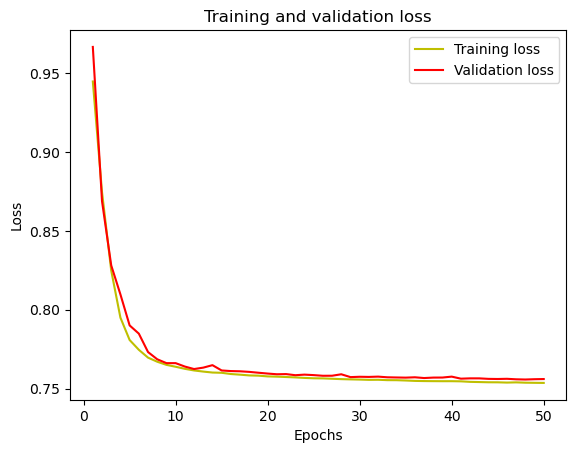

In [10]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

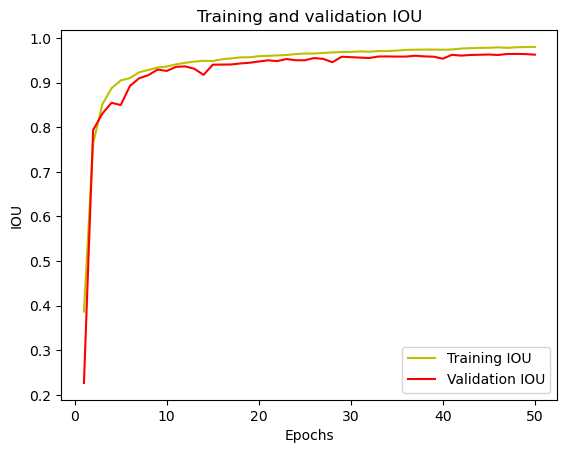

In [11]:
acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

### model ensemble

In [47]:
from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('./save_model_true_shuffle/res34.hdf5', compile=False)
model2 = load_model('./save_model_new2/inceptionv3.hdf5', compile=False)
model3 = load_model('./save_model_new2/vgg16.hdf5', compile=False)

In [48]:
models = [model1, model2, model3]
#preds = [model.predict(X_test) for model in models]

pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

6/6 [==============================] - 1s 97ms/step


In [49]:
pred1_iou = np.argmax(pred1, axis=3)
pred2_iou = np.argmax(pred2, axis=3) 
pred3_iou = np.argmax(pred3, axis=3) 

In [50]:
#model 1
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], pred1_iou)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

Mean IoU = 0.9635439
[[2.742143e+06 1.012000e+03 1.080000e+02 0.000000e+00]
 [1.021000e+03 1.368860e+05 1.648000e+03 2.270000e+02]
 [6.300000e+01 1.917000e+03 1.766230e+05 1.150000e+03]
 [2.000000e+00 4.500000e+02 1.569000e+03 4.814100e+04]]
IoU for class1 is:  0.9991962
IoU for class2 is:  0.95616823
IoU for class3 is:  0.9647418
IoU for class4 is:  0.93406934


In [51]:
#model 2
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], pred2_iou)
print("Mean IoU model 2 =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

Mean IoU model 2 = 0.9859947
[[2.742907e+06 3.360000e+02 2.000000e+01 0.000000e+00]
 [4.840000e+02 1.389470e+05 3.290000e+02 2.200000e+01]
 [4.900000e+01 1.312000e+03 1.779150e+05 4.770000e+02]
 [0.000000e+00 1.640000e+02 4.670000e+02 4.953100e+04]]
IoU for class1 is:  0.999676
IoU for class2 is:  0.9813057
IoU for class3 is:  0.98530203
IoU for class4 is:  0.97769487


In [52]:
#model 3
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], pred3_iou)
print("Mean IoU model 2 =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

Mean IoU model 2 = 0.96712154
[[2.742333e+06 8.560000e+02 7.400000e+01 0.000000e+00]
 [2.010000e+03 1.368920e+05 8.140000e+02 6.600000e+01]
 [2.960000e+02 2.321000e+03 1.765260e+05 6.100000e+02]
 [1.000000e+00 5.180000e+02 1.524000e+03 4.811900e+04]]
IoU for class1 is:  0.998821
IoU for class2 is:  0.9541041
IoU for class3 is:  0.96904457
IoU for class4 is:  0.9465164


1/1 [==============================] - 0s 27ms/step


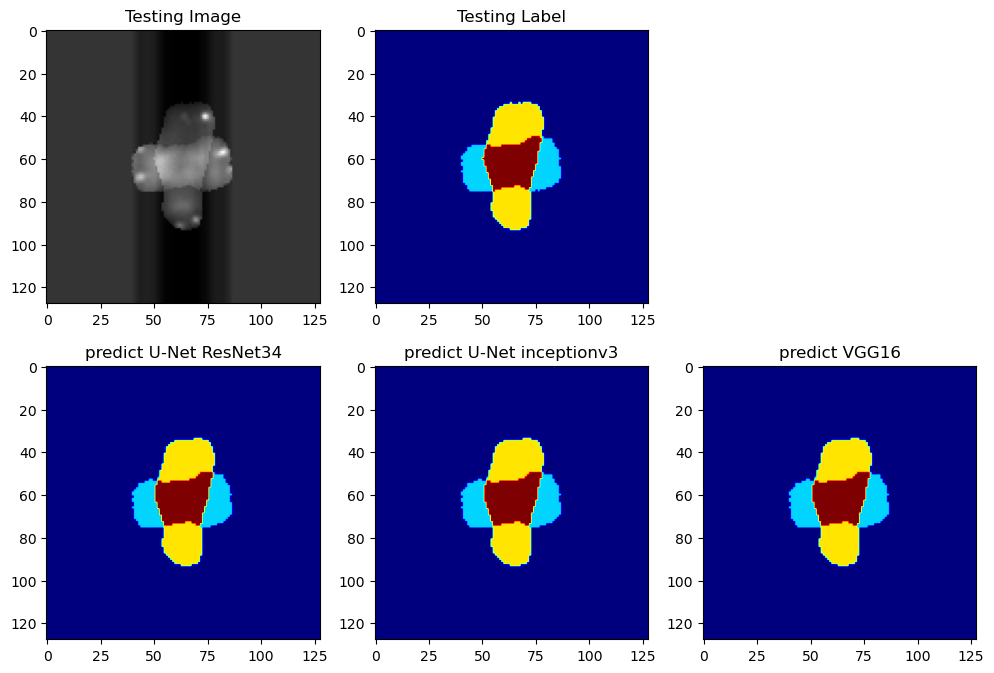

In [53]:
#test_img_number = random.randint(0, len(X_test))
test_img = X_test[4]
ground_truth=y_test[4]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction1 = (model1.predict(test_img_input))
predicted_img1=np.argmax(prediction1, axis=3)[0,:,:]

prediction2 = (model1.predict(test_img_input))
predicted_img2=np.argmax(prediction2, axis=3)[0,:,:]

prediction3 = (model1.predict(test_img_input))
predicted_img3=np.argmax(prediction3, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)  # Subplot 1
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

plt.subplot(2, 3, 2)  # Subplot 2
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(2, 3, 3)  # Subplot 3
plt.axis('off')

plt.subplot(2, 3, 4)  # Subplot 4
plt.title('predict U-Net ResNet34')
plt.imshow(predicted_img1, cmap='jet')

plt.subplot(2, 3, 5)  # Subplot 5
plt.title('predict U-Net inceptionv3')
plt.imshow(predicted_img2, cmap='jet')

plt.subplot(2, 3, 6)  # Subplot 6
plt.title('predict VGG16')
plt.imshow(predicted_img3, cmap='jet')


plt.show()

In [54]:
preds = [pred1, pred2, pred3]

In [55]:
weights = [0.2, 0.6, 0.2]

weighted_preds = np.tensordot(preds, weights, axes=((0),(0))) # memberi bobot dengan cara setiap model di kali bobot 
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)

In [56]:
y_pred1_argmax=np.argmax(pred1, axis=3)
y_pred2_argmax=np.argmax(pred2, axis=3)
y_pred3_argmax=np.argmax(pred3, axis=3)

In [57]:
#IoU
n_classes = 4
IOU1 = MeanIoU(num_classes=n_classes)  
IOU2 = MeanIoU(num_classes=n_classes)  
IOU3 = MeanIoU(num_classes=n_classes)  
IOU_weighted = MeanIoU(num_classes=n_classes)  

IOU1.update_state(y_test[:,:,:,0], y_pred1_argmax)
IOU2.update_state(y_test[:,:,:,0], y_pred2_argmax)
IOU3.update_state(y_test[:,:,:,0], y_pred3_argmax)
IOU_weighted.update_state(y_test[:,:,:,0], weighted_ensemble_prediction)


print('IOU Score for model1 = ', IOU1.result().numpy())
print('IOU Score for model2 = ', IOU2.result().numpy())
print('IOU Score for model3 = ', IOU3.result().numpy())
print('IOU Score for weighted average ensemble = ', IOU_weighted.result().numpy())

IOU Score for model1 =  0.9635439
IOU Score for model2 =  0.9859947
IOU Score for model3 =  0.96712154
IOU Score for weighted average ensemble =  0.986496


In [62]:
import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 10):
    for w2 in range(0,10):
        for w3 in range(0,10):
            if w1/10.+w2/10.+w3/10. != 1:
                continue
            else:
                wts = [w1/10.,w2/10.,w3/10.]
                
                IOU_wted = MeanIoU(num_classes=n_classes) 
                wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
                wted_ensemble_pred = np.argmax(wted_preds, axis=3)
                IOU_wted.update_state(y_test[:,:,:,0], wted_ensemble_pred)
                #print("predict bobot :", w1/10., w2/10., w3/10., " : IOU = ", IOU_wted.result().numpy())
                df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                            'wt3':wts[2], 'IOU': IOU_wted.result().numpy()}, index=[0]), ignore_index=True)
            
max_iou_row = df.iloc[df['IOU'].idxmax()]

C:\Users\tama\AppData\Local\Temp\ipykernel_2080\479039005.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
C:\Users\tama\AppData\Local\Temp\ipykernel_2080\479039005.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
C:\Users\tama\AppData\Local\Temp\ipykernel_2080\479039005.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
C:\Users\tama\AppData\Local\Temp\ipykernel_2080\479039005.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt

In [63]:
df.sort_values('IOU', ascending=False).head()

,wt1,wt2,wt3,IOU
33,0.3,0.7,0.0,0.986537
16,0.1,0.7,0.2,0.986526
25,0.2,0.6,0.2,0.986496
26,0.2,0.8,0.0,0.986366
6,0.0,0.7,0.3,0.986322


In [65]:
#model ensemblle
weights = [0.0, 0.7, 0.3]

weighted_preds = np.tensordot(preds, weights, axes=((0),(0))) # memberi bobot dengan cara setiap model di kali bobot 
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)


n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], weighted_ensemble_prediction)
print("Mean IoU model 2 =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

Mean IoU model 2 = 0.98632234
[[2.742931e+06 3.160000e+02 1.600000e+01 0.000000e+00]
 [5.130000e+02 1.389420e+05 3.070000e+02 2.000000e+01]
 [6.000000e+01 1.358000e+03 1.779120e+05 4.230000e+02]
 [0.000000e+00 1.660000e+02 4.520000e+02 4.954400e+04]]
IoU for class1 is:  0.99967015
IoU for class2 is:  0.98107636
IoU for class3 is:  0.98550916
IoU for class4 is:  0.9790337


In [66]:
n_classes = 4
IOU1 = MeanIoU(num_classes=n_classes)  
IOU2 = MeanIoU(num_classes=n_classes)  
IOU3 = MeanIoU(num_classes=n_classes)  
IOU_weighted = MeanIoU(num_classes=n_classes)  

IOU1.update_state(y_test[:,:,:,0], y_pred1_argmax)
IOU2.update_state(y_test[:,:,:,0], y_pred2_argmax)
IOU3.update_state(y_test[:,:,:,0], y_pred3_argmax)
IOU_weighted.update_state(y_test[:,:,:,0], weighted_ensemble_prediction)

print('IOU Score for model1 = ', IOU1.result().numpy())
print('IOU Score for model2 = ', IOU2.result().numpy())
print('IOU Score for model3 = ', IOU3.result().numpy())
print('IOU Score for weighted average ensemble = ', IOU_weighted.result().numpy())

IOU Score for model1 =  0.9635439
IOU Score for model2 =  0.9859947
IOU Score for model3 =  0.96712154
IOU Score for weighted average ensemble =  0.98632234


1/1 [==============================] - 0s 31ms/step


<Figure size 1200x800 with 0 Axes>

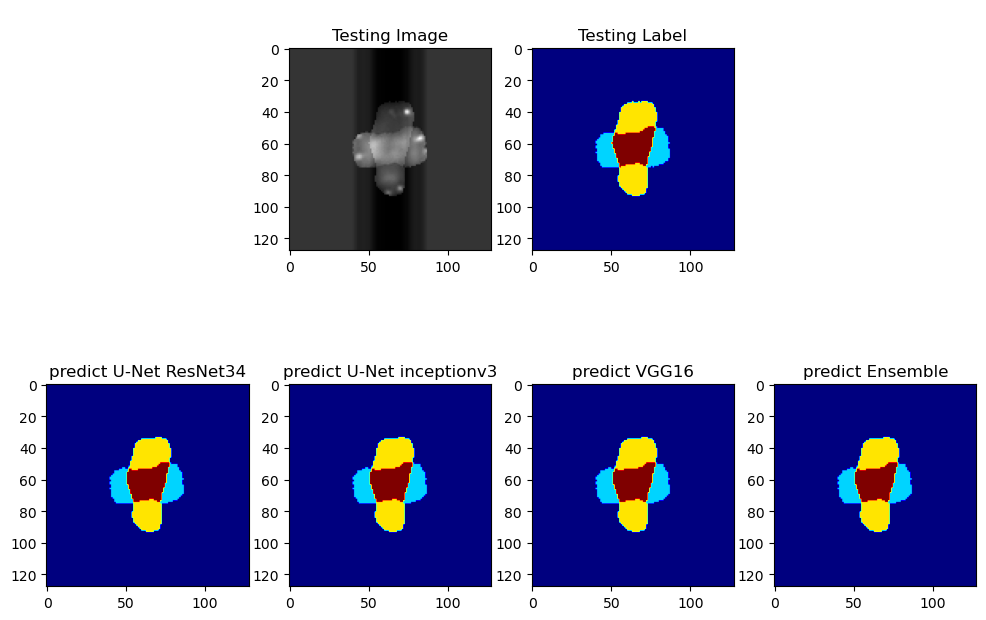

In [67]:
#test_img_number = random.randint(0, len(X_test))
test_img = X_test[4]
ground_truth=y_test[4]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction1 = (model1.predict(test_img_input))
predicted_img1=np.argmax(prediction1, axis=3)[0,:,:]

prediction2 = (model1.predict(test_img_input))
predicted_img2=np.argmax(prediction2, axis=3)[0,:,:]

prediction3 = (model1.predict(test_img_input))
predicted_img3=np.argmax(prediction3, axis=3)[0,:,:]

predic_preds = [prediction1, prediction2, prediction3]
weights = [0.3, 0.5, 0.2]
weighted_preds = np.tensordot(predic_preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))

plt.figure(figsize=(12, 8))

plt.subplot(2, 4, 1)  
plt.axis('off')

plt.subplot(2, 4, 2) 
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

plt.subplot(2, 4, 3) 
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(2, 4, 4)
plt.axis('off')

plt.subplot(2, 4, 5) 
plt.title('predict U-Net ResNet34')
plt.imshow(predicted_img1, cmap='jet')

plt.subplot(2, 4, 6)  
plt.title('predict U-Net inceptionv3')
plt.imshow(predicted_img2, cmap='jet')

plt.subplot(2, 4, 7) 
plt.title('predict VGG16')
plt.imshow(predicted_img3, cmap='jet')

plt.subplot(2, 4, 8) 
plt.title('predict Ensemble')
plt.imshow(weighted_ensemble_prediction, cmap='jet')

plt.show()

### Eval Journal

In [68]:
weights = [0.0, 0.7, 0.3]

weighted_preds = np.tensordot(preds, weights, axes=((0),(0))) # memberi bobot dengan cara setiap model di kali bobot 
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)


n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], weighted_ensemble_prediction)
IOU_keras.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.98632234>

In [69]:
iou_class4_list = [] 

for i in range(len(weighted_ensemble_prediction)):
    IOU_keras.reset_states()  # Reset state IOU
    IOU_keras.update_state(y_test[i, :, :, 0], weighted_ensemble_prediction[i])
    iou_class4 = IOU_keras.result().numpy()
    iou_class4_list.append(iou_class4)

for i, iou in enumerate(iou_class4_list):
    print(f"Image {i+1} - IoU Class 4: {iou}")

Image 1 - IoU Class 4: 0.9452108144760132
Image 2 - IoU Class 4: 0.9585504531860352
Image 3 - IoU Class 4: 0.9801466464996338
Image 4 - IoU Class 4: 0.863914430141449
Image 5 - IoU Class 4: 0.9911502599716187
Image 6 - IoU Class 4: 0.9501047134399414
Image 7 - IoU Class 4: 0.9720934629440308
Image 8 - IoU Class 4: 0.9892282485961914
Image 9 - IoU Class 4: 0.9655598402023315
Image 10 - IoU Class 4: 0.9652393460273743
Image 11 - IoU Class 4: 0.9940299391746521
Image 12 - IoU Class 4: 0.9714791178703308
Image 13 - IoU Class 4: 0.7424101829528809
Image 14 - IoU Class 4: 0.9649031162261963
Image 15 - IoU Class 4: 0.9731028079986572
Image 16 - IoU Class 4: 0.7925914525985718
Image 17 - IoU Class 4: 0.9752534627914429
Image 18 - IoU Class 4: 0.9731823205947876
Image 19 - IoU Class 4: 0.9539816975593567
Image 20 - IoU Class 4: 0.9795913100242615
Image 21 - IoU Class 4: 0.96964031457901
Image 22 - IoU Class 4: 0.9789983034133911
Image 23 - IoU Class 4: 0.9702743291854858
Image 24 - IoU Class 4: